# 摘要

# 理论模型

**炼铁**

中国钢材绝大部分以铁矿石为基本原料冶炼生产。炼铁工艺的生产成本构成主要为原材料（球团、铁矿石等）、辅助材料（石灰石、 白云石、耐火材料等）、燃料及动力（焦炭、煤粉、煤气、氧气、水、电等）、直接工资和福利、制造费用、成本扣除（煤气回收、 水渣回收、焦炭筛下物回收等）。根据高炉冶炼原理，生产 1 吨生铁，需要 1.5-2.0 吨铁矿石、0.4-0.6 吨焦炭和 0.2-0.4 吨熔剂。炼铁工艺中影响总成本的主要因素是原料（铁矿石、焦炭）成本，而包括辅料、燃料、人工费用在内的其他费用与副产品回收进行冲抵后仅占总成本的 10% 左右。

生铁制造成本(每吨) ＝(1.6 × 铁矿石 + 0.5 × 焦炭) / 0.9


**炼钢**

炼钢工艺的生产成本构成主要为生铁、废钢、合金、电极、耐火材料、 辅助材料、电能、维检和其他等费用。我国目前主要的炼钢工艺为转炉炼钢，一般需配置10%-15%的废钢。炼钢工艺中因为耗电量的增加、合金的加入以及维检费用的上升，使得除主要原料外的其他费用占到炼钢总成本的 18% 左右。

粗钢制造成本(每吨) ＝ (0.96 × 生铁 + 0.15 × 废钢) / 0.82

**轧钢**

轧钢工艺（热轧）的生产成本构成主要是燃气、电能、轧辊损耗等费用。不同品种轧制成本略有差别，总体在 150-300 元/吨。

简单来看，螺纹钢和铁矿石、焦炭的价格（每吨）满足：

螺纹钢成本 = 1.6 × 铁矿石价格 +  0.5 × 焦炭价格 + 其他成本

炼钢利润 = 螺纹钢价格 - 螺纹钢成本

那么螺纹钢、铁矿石以及焦炭价差的波动就是炼钢利润的波动，价差均值回归的逻辑是：如果炼钢利润过高，钢厂会提高开工率，铁矿和焦炭价格会跟涨，挤压炼钢利润；如果炼钢利润过低，钢厂会选择减产，钢材价格回升。


# 实证分析

In [1]:
# coding=utf-8
import sys
sys.path.append("D:\\HST\\QuantStudio")
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2()

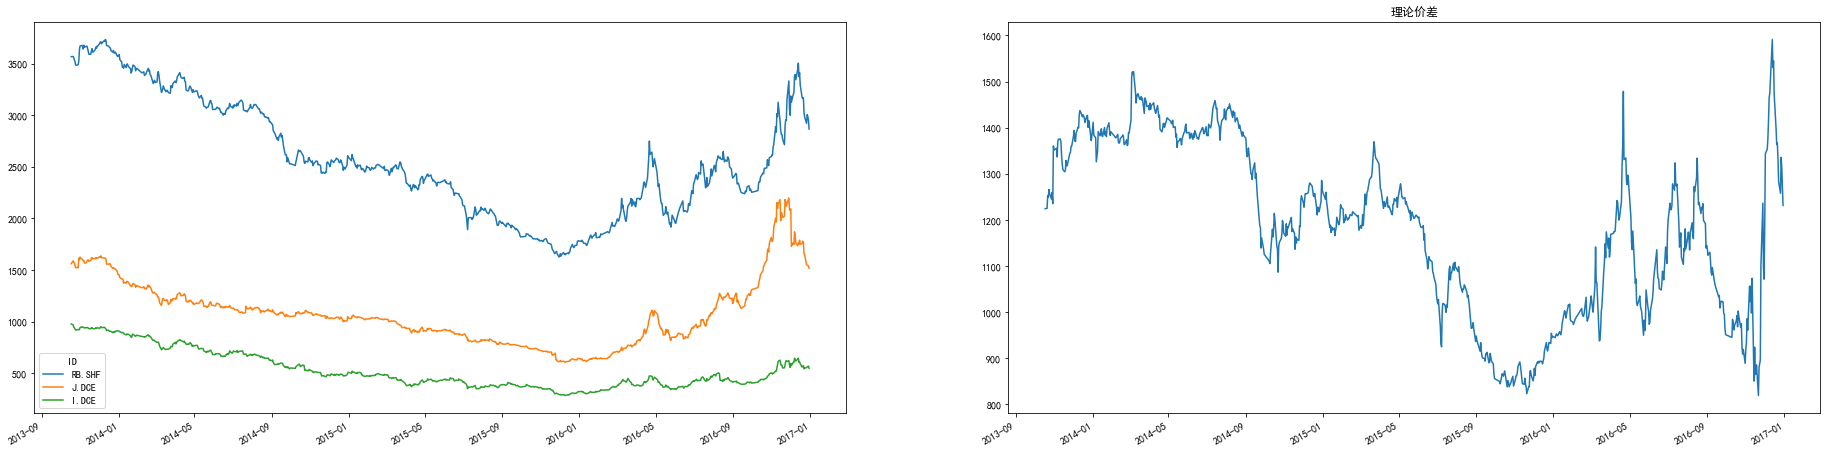

In [18]:
# 参数设置和数据准备
Exchange = "DCE"
IDs = ["RB.SHF", "J.DCE", "I.DCE"]# 螺纹钢, 焦炭，铁矿石主力合约
# IDs = ["RB01.SHF", "J01.DCE", "I01.DCE"]# 螺纹钢, 焦炭，铁矿石连一合约
TheoryHedgeRatio = np.array([1, -0.5, -1.6])# 理论价差
StartDT = dt.datetime(2013, 10, 18)# 设置回测开始日期
EndDT = dt.datetime(2016, 12, 31)# 回测截止日期
PriceFactor = "收盘价(元)"

WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid=Exchange, start_dt=StartDT, end_dt=EndDT)
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=IDs, dts=DTs).iloc[0,:,:]
# 获取价格数据
FT = WDB.getTable("中国商品期货日行情")
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
MonthPrice = FT.readData(factor_names=[PriceFactor], ids=MonthIDs, dts=DTs).iloc[0]
CCPrice = FT.readData(factor_names=[PriceFactor], ids=FutureIDMap.columns.tolist(), dts=DTs).iloc[0]
WDB.disconnect()

# 对连续合约的价格进行展期调整
AdjCCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in FutureIDMap.columns}
AdjCCPrice = pd.DataFrame(AdjCCPrice).loc[:, FutureIDMap.columns]

Fig, Axes = plt.subplots(1, 2, figsize=(32, 8))
CCPrice.plot(kind="line", ax=Axes[0])
(CCPrice * TheoryHedgeRatio).sum(axis=1).plot(kind="line", ax=Axes[1], title="理论价差");

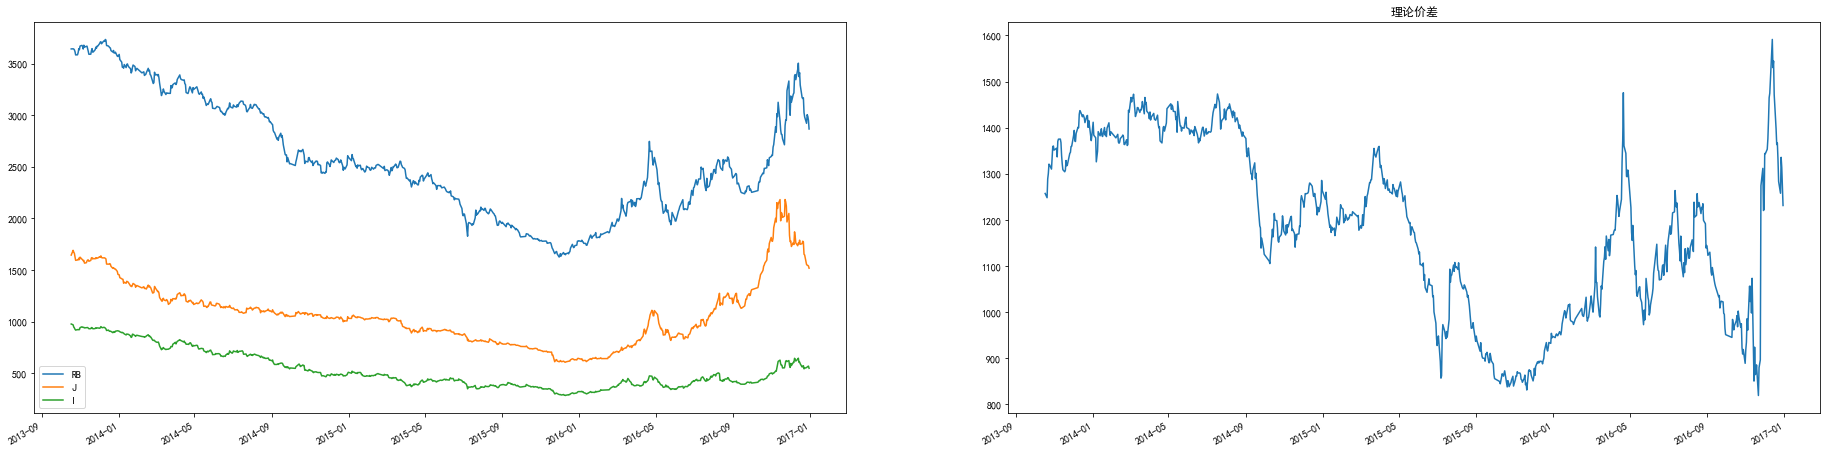

In [19]:
# 使用对齐交割月的价格数据
import re
Exchange = "DCE"
BenchmarkID = "I.DCE"# 作为标准的主力合约
Codes = ["RB", "J", "I"]# 合约代码
ExchangeSuffix = ["SHF", "DCE", "DCE"]# 交易所后缀
TheoryHedgeRatio = np.array([1, -0.5, -1.6])# 理论价差
StartDT = dt.datetime(2013, 10, 18)# 回测开始日期
EndDT = dt.datetime(2016, 12, 31)# 回测截止日期
PriceFactor = "收盘价(元)"

# 以焦炭的主力合约为准
WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid=Exchange, start_dt=StartDT, end_dt=EndDT)
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=[BenchmarkID], dts=DTs).iloc[0,:,:]
for i, iCode in enumerate(Codes):
    FutureIDMap[iCode] = FutureIDMap.iloc[:, 0].apply(lambda x: iCode+re.sub("\D", "", x)+"."+ExchangeSuffix[i])
FutureIDMap.pop(BenchmarkID)
# 获取价格数据
FT = WDB.getTable("中国商品期货日行情")
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
MonthPrice = FT.readData(factor_names=[PriceFactor], ids=MonthIDs, dts=DTs).iloc[0]
WDB.disconnect()

# 生成连续合约的价格
CCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_type="价格不变") for iID in FutureIDMap.columns}
CCPrice = pd.DataFrame(CCPrice).loc[:, FutureIDMap.columns]
# 对连续合约的价格进行展期调整
AdjCCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in FutureIDMap.columns}
AdjCCPrice = pd.DataFrame(AdjCCPrice).loc[:, FutureIDMap.columns]

Fig, Axes = plt.subplots(1, 2, figsize=(32, 8))
CCPrice.plot(kind="line", ax=Axes[0])
(CCPrice * TheoryHedgeRatio).sum(axis=1).plot(kind="line", ax=Axes[1], title="理论价差");

In [3]:
# --------平稳性检验--------
# ADF 检验
RBADFTest = sm.tsa.stattools.adfuller(CCPrice.values[:, 0], regression='c', autolag="BIC")
print("----------- 螺纹钢价格 ADF Test ----------",
      ("Statistic : %f" % RBADFTest[0]), 
      ("pvalue : %f" % RBADFTest[1]), 
      ("usedlag : %d" % RBADFTest[2]), sep="\n", end="\n\n")

JADFTest = sm.tsa.stattools.adfuller(CCPrice.values[:, 1], regression='c', autolag="BIC")
print("----------- 焦炭价格 ADF Test ----------",
      ("Statistic : %f" % JADFTest[0]), 
      ("pvalue : %f" % JADFTest[1]), 
      ("usedlag : %d" % JADFTest[2]), sep="\n", end="\n\n")
IADFTest = sm.tsa.stattools.adfuller(CCPrice.values[:, 2], regression='c', autolag="BIC")
print("----------- 铁矿石价格 ADF Test ----------",
      ("Statistic : %f" % IADFTest[0]), 
      ("pvalue : %f" % IADFTest[1]), 
      ("usedlag : %d" % IADFTest[2]), sep="\n")

RBADFTest = sm.tsa.stattools.adfuller(np.diff(AdjCCPrice.values[:, 0]), regression='c', autolag="BIC")
print("----------- Diff(螺纹钢价格, 1) ADF Test ----------",
      ("Statistic : %f" % RBADFTest[0]), 
      ("pvalue : %f" % RBADFTest[1]), 
      ("usedlag : %d" % RBADFTest[2]), sep="\n")

JADFTest = sm.tsa.stattools.adfuller(np.diff(AdjCCPrice.values[:, 1]), regression='c', autolag="BIC")
print("----------- Diff(焦炭价格, 1) ADF Test ----------",
      ("Statistic : %f" % JADFTest[0]), 
      ("pvalue : %f" % JADFTest[1]), 
      ("usedlag : %d" % JADFTest[2]), sep="\n")
IADFTest = sm.tsa.stattools.adfuller(np.diff(AdjCCPrice.values[:, 2]), regression='c', autolag="BIC")
print("----------- Diff(铁矿石价格, 1) ADF Test ----------",
      ("Statistic : %f" % IADFTest[0]), 
      ("pvalue : %f" % IADFTest[1]), 
      ("usedlag : %d" % IADFTest[2]), sep="\n")

----------- 螺纹钢价格 ADF Test ----------
Statistic : -1.737608
pvalue : 0.411847
usedlag : 0

----------- 焦炭价格 ADF Test ----------
Statistic : 1.299001
pvalue : 0.996603
usedlag : 0

----------- 铁矿石价格 ADF Test ----------
Statistic : -2.096685
pvalue : 0.245849
usedlag : 0
----------- Diff(螺纹钢价格, 1) ADF Test ----------
Statistic : -23.051518
pvalue : 0.000000
usedlag : 0
----------- Diff(焦炭价格, 1) ADF Test ----------
Statistic : -12.091003
pvalue : 0.000000
usedlag : 2
----------- Diff(铁矿石价格, 1) ADF Test ----------
Statistic : -13.905084
pvalue : 0.000000
usedlag : 4


----------- 螺纹钢-焦炭-铁矿石 Cointegration Johansen Test: r<=0 -----------
Trace Statistic: 27.634598
Critical Values (90%, 95%, 99%): [27.0669 29.7961 35.4628]
Maximum Eigenvalue Statistic Statistic: 15.155951
Critical Values (90%, 95%, 99%): [18.8928 21.1314 25.865 ]
----------- 螺纹钢-焦炭-铁矿石 Cointegration Johansen Test: r<=1 -----------
Trace Statistic: 12.478647
Critical Values (90%, 95%, 99%): [13.4294 15.4943 19.9349]
Maximum Eigenvalue Statistic Statistic: 10.861024
Critical Values (90%, 95%, 99%): [12.2971 14.2639 18.52  ]
----------- 螺纹钢-焦炭-铁矿石 Cointegration Johansen Test: r<=2 -----------
Trace Statistic: 1.617623
Critical Values (90%, 95%, 99%): [2.7055 3.8415 6.6349]
Maximum Eigenvalue Statistic Statistic: 1.617623
Critical Values (90%, 95%, 99%): [2.7055 3.8415 6.6349]
对冲比例: [ 1.         -0.61694666 -2.19167428]


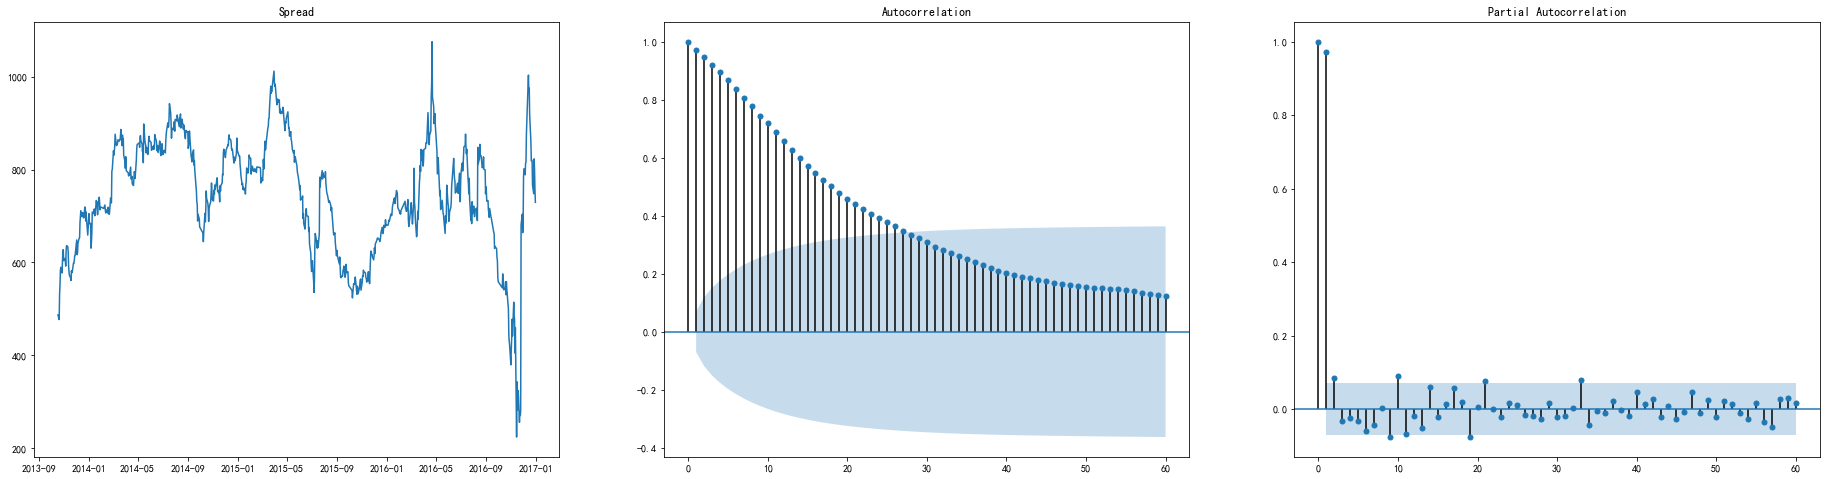

In [14]:
# --------协整检验--------
CointJohansenTest = sm.tsa.var.vecm.coint_johansen(CCPrice.values, det_order=0, k_ar_diff=1)
for i in range(CointJohansenTest.lr1.shape[0]):
    print(("----------- 螺纹钢-焦炭-铁矿石 Cointegration Johansen Test: r<=%d -----------" % (i, )),
          ("Trace Statistic: %f" % (CointJohansenTest.lr1[i], )), 
          ("Critical Values (90%%, 95%%, 99%%): %s" % (str(CointJohansenTest.cvt[i]), )), 
          ("Maximum Eigenvalue Statistic Statistic: %f" % (CointJohansenTest.lr2[i], )), 
          ("Critical Values (90%%, 95%%, 99%%): %s" % (str(CointJohansenTest.cvm[i]), )), sep="\n")

HedgeRatio = CointJohansenTest.evec[:, 0] / CointJohansenTest.evec[0, 0]
print("对冲比例: %s" % str(HedgeRatio))

Spread = (CCPrice * HedgeRatio).sum(axis=1)

Fig, Axes = plt.subplots(1, 3, figsize=(32, 8))
Axes[0].plot(Spread)
Axes[0].set_title("Spread")
sm.graphics.tsa.plot_acf(Spread, lags=60, ax=Axes[1])
sm.graphics.tsa.plot_pacf(Spread, lags=60, ax=Axes[2]);

HalfLife: 23.280366


,0
起始时点,2013-10-18 00:00:00
结束时点,2016-12-30 00:00:00
时点数,786
总收益率,0.0352651
年化收益率,0.01088
年化波动率,0.0532994
Sharpe比率,0.20413
胜率,0.793893
最大回撤率,0.0816065
最大回撤开始时点,2016-08-31 00:00:00


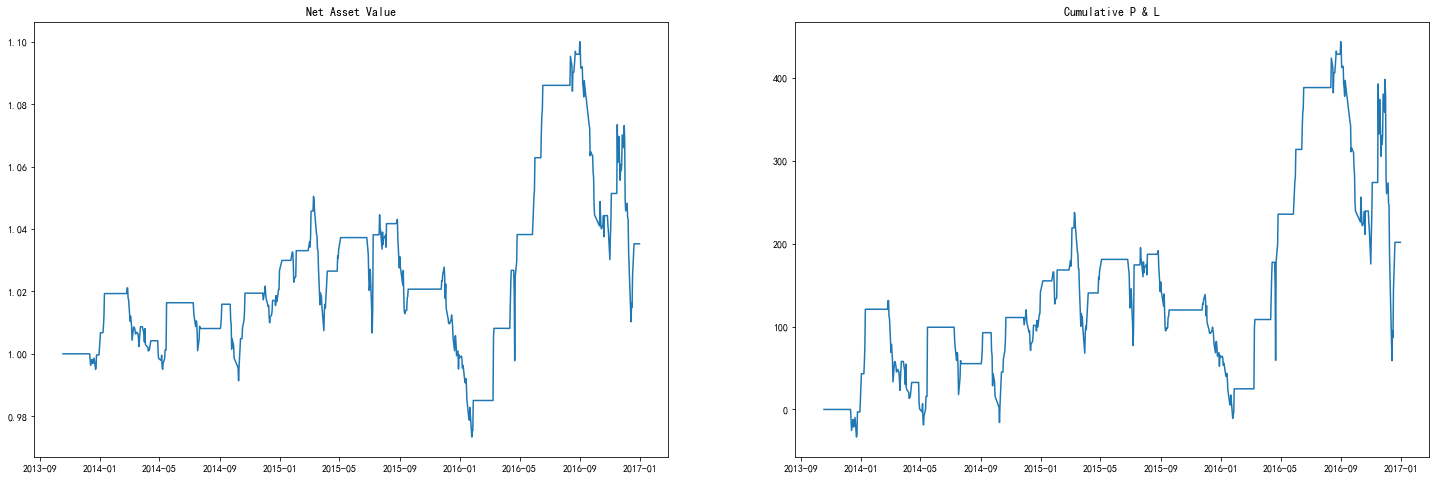

In [16]:
# --------Spread 策略--------
EntryThreshold, ExitThreshold = 2, 0
# NumRatio = np.array([1, -0.5, -1.6])
NumRatio = HedgeRatio

# 生成信号
Spread = (CCPrice * NumRatio).sum(axis=1)
HalfLife = - np.log(2) / sm.OLS(np.diff(Spread.values), sm.add_constant(Spread.values[:-1], prepend=False)).fit().params[0]
print("HalfLife: %f" % HalfLife)
LookBack = 10
# LookBack = max(5, int(round(HalfLife)))
Zscore = (Spread - Spread.rolling(LookBack).mean()) / Spread.rolling(LookBack).cov()**0.5
NumUnits = np.full(shape=(CCPrice.shape[0], ), fill_value=np.nan)
# 空头信号
Mask = (Zscore.values>EntryThreshold)
NumUnits[Mask] = -1
# 多头信号
Mask = (Zscore.values<-EntryThreshold)
NumUnits[Mask] = 1
# 平仓信号
PreNumUnits = pd.Series(NumUnits).fillna(method="pad").values
NumUnits[(PreNumUnits==1) & (Zscore.values>=-ExitThreshold)] = 0
NumUnits[(PreNumUnits==-1) & (Zscore.values<=ExitThreshold)] = 0
# 填充缺失
NumUnits[0] = (0 if pd.isnull(NumUnits[0]) else NumUnits[0])
NumUnits = pd.Series(NumUnits).fillna(method="pad").values
# 策略回测
NumUnits = NumUnits.reshape((NumUnits.shape[0],1)).repeat(NumRatio.shape[0], axis=1) * NumRatio
Return, PNL, _, _ = QS.Tools.Strategy.testNumStrategy(NumUnits * CCPrice.values / AdjCCPrice.values, AdjCCPrice.values)
Return, PNL = pd.Series(Return, index=CCPrice.index), pd.DataFrame(PNL, index=CCPrice.index, columns=CCPrice.columns)
NAV = (1 + Return).cumprod()

# 展示策略表现
display(QS.Tools.Strategy.summaryStrategy(NAV.values, dts=NAV.index.tolist()))
Fig, Axes = plt.subplots(1, 2, figsize=(25, 8))
Axes[0].plot(NAV)
Axes[0].set_title("Net Asset Value")
Axes[1].plot(PNL.sum(axis=1).cumsum())
Axes[1].set_title("Cumulative P & L");